# sell-in-may-and-go-away

see: https://en.wikipedia.org/wiki/Sell_in_May

"Sell in May and go away" (aka the Halloween indicator) is an investment adage warning investors to divest their stock holdings in May and wait to reinvest in November.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Define Strategy Class

In [4]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end
        
        self.ts = None
        self.rlog = None
        self.tlog = None
        self.dbal = None
        self.stats = None

    def _algo(self):
        pf.TradeLog.cash = capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)

            # Buy (at the open on first trading day in Nov).
            if self.tlog.shares == 0:
                if row.month == 11 and row.first_dotm:
                    self.tlog.buy(date, row.open)
            # Sell (at the open on first trading day in May).
            else:
                if ((row.month == 5 and row.first_dotm) or end_flag):
                    self.tlog.sell(date, row.open)

            # Record daily balance
            self.dbal.append(date, high, low, close)

    def run(self):
        
        # Fetch and select timeseries.
        self.ts = pf.fetch_timeseries(self.symbol)
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end,
                                        use_adj=True)
        # Add calendar columns.
        self.ts = pf.calendar(self.ts)
        
        # Finalize timeseries.
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start)
        
        # Create tlog and dbal objects
        self.tlog = pf.TradeLog(symbol)
        self.dbal = pf.DailyBal()
        
        # Run algorithm, get logs
        self._algo()
        self._get_logs()
        self._get_stats()

    def _get_logs(self):
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)

    def _get_stats(self):
        s.stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)

Run Strategy

In [5]:
s = Strategy(symbol, capital, start, end)
s.run()

Examine logs

In [6]:
# The raw trade log show each entry or exit entry.
s.rlog.tail()

,date,seq_num,price,shares,entry_exit,direction,symbol
121,2018-05-01,121,2642.96,145,exit,LONG,^GSPC
122,2018-11-01,122,2717.58,141,entry,LONG,^GSPC
123,2019-05-01,123,2952.33,141,exit,LONG,^GSPC
124,2019-11-01,124,3050.72,136,entry,LONG,^GSPC
125,2020-05-01,125,2869.09,136,exit,LONG,^GSPC


In [7]:
# The trade log shows matching entry and exits orders
s.tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
58,2015-11-02,2080.76,2016-05-02,2067.17,-13.59,-2188.00,161,324283.92,LONG,^GSPC
59,2016-11-01,2128.68,2017-05-01,2388.50,259.82,40791.75,157,365075.67,LONG,^GSPC
60,2017-11-01,2583.21,2018-05-01,2642.96,59.75,8663.75,145,373739.42,LONG,^GSPC
61,2018-11-01,2717.58,2019-05-01,2952.33,234.75,33099.75,141,406839.17,LONG,^GSPC
62,2019-11-01,3050.72,2020-05-01,2869.09,-181.63,-24701.66,136,382137.51,LONG,^GSPC


In [8]:
# The daily balance
s.dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-10-12,392137.51,392137.51,392137.51,0,392137.51,1.00,-
2020-10-13,392137.51,392137.51,392137.51,0,392137.51,1.00,-
2020-10-14,392137.51,392137.51,392137.51,0,392137.51,1.00,-
2020-10-15,392137.51,392137.51,392137.51,0,392137.51,1.00,-
2020-10-16,392137.51,392137.51,392137.51,0,392137.51,1.00,-


All available stastics

In [9]:
pf.print_full(s.stats)

start                                                   1957-03-04
end                                                     2020-10-16
beginning_balance                                            10000
ending_balance                                           392137.51
total_net_profit                                         382137.51
gross_profit                                             496095.24
gross_loss                                              -113957.73
profit_factor                                                 4.35
return_on_initial_capital                                  3821.38
annual_return_rate                                            5.94
trading_period                           63 years 7 months 12 days
pct_time_in_market                                           48.66
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [10]:
benchmark = pf.Benchmark(symbol, s.capital, s.start, s.end)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

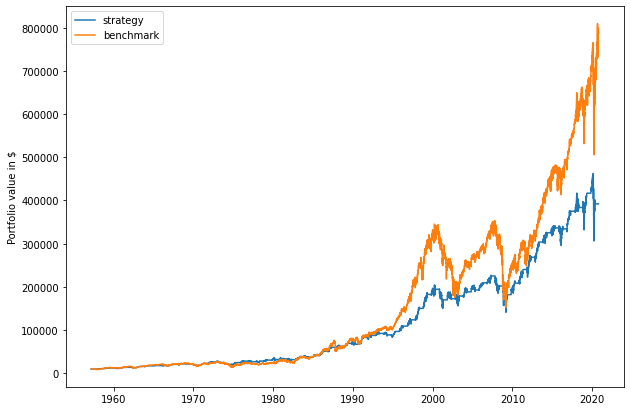

In [11]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Plot Trades

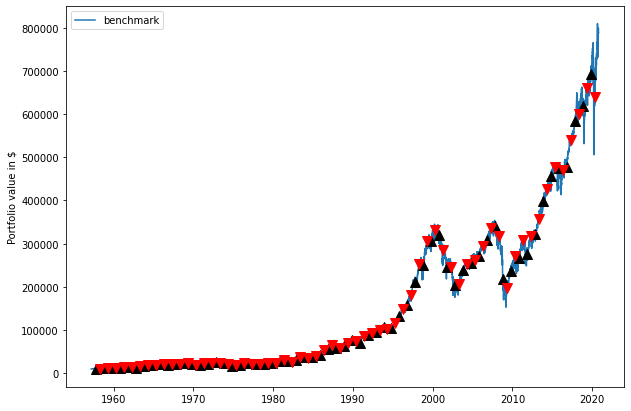

In [12]:
pf.plot_trades(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,5.94,7.10
max_closed_out_drawdown,-37.82,-56.77
annualized_return_over_max_drawdown,0.16,0.13
best_month,23.41,23.49
worst_month,-30.81,-30.94
sharpe_ratio,0.58,0.51
sortino_ratio,0.52,0.65
monthly_std,2.95,4.28
annual_std,10.02,15.66


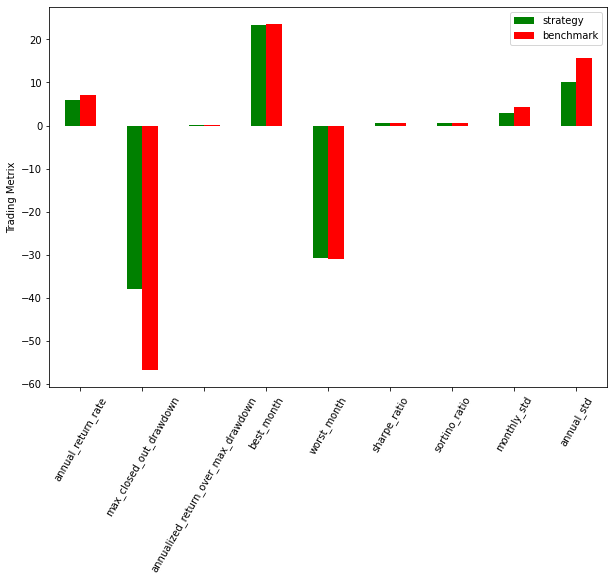

In [13]:
df = pf.plot_bar_graph(s.stats, benchmark.stats)
df